In [158]:
import numpy as np
import torch
from torch.autograd import grad
from tqdm import tqdm

class KDE(torch.nn.Module):
    def __init__(self, bandwidth=1):
        super(KDE, self).__init__()
        self.bandwidth = bandwidth
        self.data = None

    def fit(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def score_samples(self, x):
        diffs = x.unsqueeze(1) - self.data.unsqueeze(0)
        distances = -0.5 * (diffs ** 2).sum(dim=2) / (self.bandwidth ** 2)
        log_probs = torch.logsumexp(distances, dim=1) - torch.log(torch.tensor(self.data.shape[0], dtype=torch.float32)) \
                    - 0.5 * self.data.shape[1] * torch.log(torch.tensor(2 * torch.pi * self.bandwidth ** 2))
        return log_probs

def load_and_sample_data(file_path, sample_size,label):
    data_all = np.load(file_path)
    data_ = data_all['z']
    labels = data_all['labels']
    data = data_[labels == label]
    data_sample = data[np.random.choice(data.shape[0], sample_size, replace=False)]
    # print("data shape:",data.shape,"data_sample shape",data_sample.shape)
    return data, data_sample

def log_p(kde, x):
    return kde.score_samples(x)

def grad_log_p(kde, x):
    x = x.clone().detach().requires_grad_(True)
    log_px = log_p(kde, x)
    grad_px = grad(log_px.sum(), x, create_graph=True)[0]
    return grad_px

def check_lipschitz(data, kde, n_samples):
    idx1 = np.random.choice(data.shape[0], n_samples, replace=False)
    idx2 = np.random.choice(data.shape[0], n_samples, replace=False)
    x1 = data[idx1]
    x2 = data[idx2]

    grad_x1 = grad_log_p(kde, x1)
    grad_x2 = grad_log_p(kde, x2)

    grad_diff = torch.norm(grad_x1 - grad_x2, dim=1)
    x_diff = torch.norm(x1 - x2, dim=1)

    valid_mask = x_diff > 1e-6
    lip_constants = grad_diff[valid_mask] / x_diff[valid_mask]

    return lip_constants.max().item()

def run_lipschitz_checks(file_path, num_runs=100, samples_size = 1000, bandwidth=1.0, n_samples=50,label=0):
    data, data_sample = load_and_sample_data(file_path, samples_size,label)
    kde = KDE(bandwidth=bandwidth)
    kde.fit(data_sample)
    data_torch = torch.tensor(data, dtype=torch.float32)

    results = []
    for _ in tqdm(range(num_runs), desc="Running Lipschitz checks"):
        L = check_lipschitz(data_torch, kde, n_samples)
        # print("L:",L)
        results.append(L)

    return results



In [169]:
num_runs = 100
samples_size = 200
n_samples = 50
label = 500
file_path = '/cpfs01/user/hanyujin/ldm/latent/exp071-vit_dinob_full_ae128_d16_movqv2_latent_no_drop_token.npz'
results_71 = run_lipschitz_checks(file_path, num_runs=num_runs, samples_size = samples_size, n_samples =n_samples)
print("Lipschitz constants:", results_71)

Running Lipschitz checks: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]

Lipschitz constants: [1.299088716506958, 1.3252986669540405, 1.3299931287765503, 1.2698793411254883, 1.3185137510299683, 1.3545875549316406, 1.2900574207305908, 1.3271820545196533, 1.291247844696045, 1.3338136672973633, 1.3064675331115723, 1.2957628965377808, 1.3023523092269897, 1.3003783226013184, 1.324508786201477, 1.3552007675170898, 1.306729793548584, 1.31749427318573, 1.3502360582351685, 1.3374453783035278, 1.2871003150939941, 1.266236662864685, 1.3192065954208374, 1.3283889293670654, 1.2927958965301514, 1.3125075101852417, 1.3375273942947388, 1.2801644802093506, 1.2985917329788208, 1.3100470304489136, 1.3234922885894775, 1.3374717235565186, 1.3156663179397583, 1.4021861553192139, 1.3214373588562012, 1.2802655696868896, 1.3262500762939453, 1.3367207050323486, 1.3141545057296753, 1.2889305353164673, 1.3352549076080322, 1.3351987600326538, 1.297291874885559, 1.3089205026626587, 1.38802170753479, 1.3203415870666504, 1.2775973081588745, 1.2855770587921143, 1.3052557706832886, 1.399015

In [170]:
# 使用示例
file_path = '/cpfs01/user/hanyujin/ldm/latent/exp072-vit_dinob_full_ae128_d16_movqv2_latent_dropmin005-075.npz'
results_72 = run_lipschitz_checks(file_path, num_runs=num_runs, samples_size = samples_size,label = label)
print("Lipschitz constants:", results_72)

Running Lipschitz checks: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]

Lipschitz constants: [1.3121376037597656, 1.3331122398376465, 1.321178674697876, 1.316713809967041, 1.3240517377853394, 1.287115454673767, 1.3315746784210205, 1.3224036693572998, 1.2922425270080566, 1.2713334560394287, 1.2944245338439941, 1.309921145439148, 1.313976764678955, 1.3734498023986816, 1.3418956995010376, 1.3695510625839233, 1.2755941152572632, 1.3471198081970215, 1.3059533834457397, 1.3092031478881836, 1.3020946979522705, 1.3493385314941406, 1.3167243003845215, 1.2963526248931885, 1.3003265857696533, 1.2786173820495605, 1.2730190753936768, 1.3244704008102417, 1.3303942680358887, 1.2794373035430908, 1.3529024124145508, 1.2896925210952759, 1.28848135471344, 1.2674379348754883, 1.356174111366272, 1.3101752996444702, 1.2803633213043213, 1.4259350299835205, 1.3132696151733398, 1.3056954145431519, 1.3261274099349976, 1.3772082328796387, 1.3015912771224976, 1.3735671043395996, 1.2842564582824707, 1.3477613925933838, 1.3303760290145874, 1.2668800354003906, 1.2890174388885498, 1.2865

In [171]:
file_path = '/cpfs01/user/hanyujin/ldm/latent/exp073-vit_dinob_full_ae128_d16_movqv2_latent_dropmin005-075_decoders.npz'
results_73 = run_lipschitz_checks(file_path, num_runs=num_runs, samples_size = samples_size)
print("Lipschitz constants:", results_73)

Running Lipschitz checks: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]

Lipschitz constants: [1.3734123706817627, 1.3145779371261597, 1.3831087350845337, 1.3080140352249146, 1.307032585144043, 1.2919222116470337, 1.255782961845398, 1.3289912939071655, 1.3326369524002075, 1.3132768869400024, 1.269171118736267, 1.2813715934753418, 1.2917526960372925, 1.3175194263458252, 1.3036906719207764, 1.3335270881652832, 1.2683502435684204, 1.279964566230774, 1.3516449928283691, 1.3069525957107544, 1.3362417221069336, 1.274273157119751, 1.2730618715286255, 1.3265513181686401, 1.3065812587738037, 1.3531805276870728, 1.2877306938171387, 1.2911087274551392, 1.3519765138626099, 1.2850018739700317, 1.2900500297546387, 1.3306046724319458, 1.3468518257141113, 1.2739485502243042, 1.318772554397583, 1.2875621318817139, 1.3285400867462158, 1.2667313814163208, 1.299195408821106, 1.3319200277328491, 1.302747368812561, 1.2828534841537476, 1.311714768409729, 1.3135316371917725, 1.3380250930786133, 1.318969964981079, 1.3055750131607056, 1.2914440631866455, 1.3222784996032715, 1.329439

Data 71 - Mean Lipschitz: 1.3193111062049865, 95% CI: (1.2680976212024688, 1.4006800025701522)
Data 72 - Mean Lipschitz: 1.3095657694339753, 95% CI: (1.256582537293434, 1.3735113859176635)
Data 73 - Mean Lipschitz: 1.3093877398967744, 95% CI: (1.2657671988010406, 1.3663897544145582)


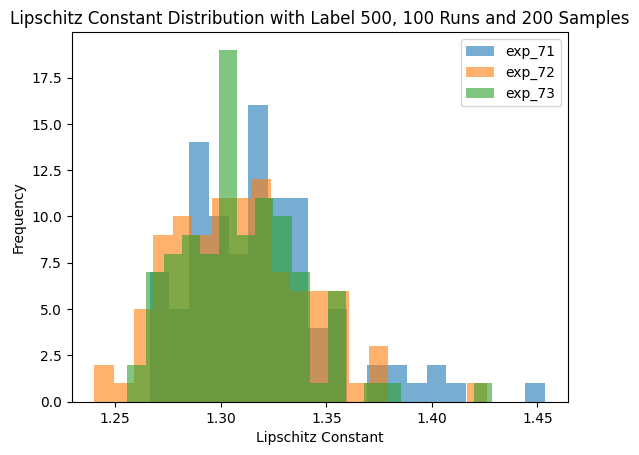

In [172]:
alpha=0.05
mean_lip_71 = np.mean(results_71)
lower_bound_71 = np.percentile(results_71, 100 * (alpha / 2))
upper_bound_71 = np.percentile(results_71, 100 * (1 - alpha / 2))

mean_lip_72 = np.mean(results_72)
lower_bound_72 = np.percentile(results_72, 100 * (alpha / 2))
upper_bound_72 = np.percentile(results_72, 100 * (1 - alpha / 2))

mean_lip_73 = np.mean(results_73)
lower_bound_73 = np.percentile(results_73, 100 * (alpha / 2))
upper_bound_73 = np.percentile(results_73, 100 * (1 - alpha / 2))

print(f"Data 71 - Mean Lipschitz: {mean_lip_71}, 95% CI: {(lower_bound_71, upper_bound_71)}")
print(f"Data 72 - Mean Lipschitz: {mean_lip_72}, 95% CI: {(lower_bound_72, upper_bound_72)}")
print(f"Data 73 - Mean Lipschitz: {mean_lip_73}, 95% CI: {(lower_bound_73, upper_bound_73)}")

import matplotlib.pyplot as plt
plt.hist(results_71, bins=20, alpha=0.6, label='exp_71')
plt.hist(results_72, bins=20, alpha=0.6, label='exp_72')
plt.hist(results_73, bins=20, alpha=0.6, label='exp_73')
plt.xlabel('Lipschitz Constant')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Lipschitz Constant Distribution with Label {label}, {num_runs} Runs and {samples_size} Samples')
plt.show()

In [63]:
file_path = '/cpfs01/user/hanyujin/ldm/latent/exp073-vit_dinob_full_ae128_d16_movqv2_latent_dropmin005-075_decoders.npz'
data_all = np.load(file_path)
a = data_all['z']
print(a.shape)
latents_bias = np.mean(a, axis=0)
latents_scale = np.std(a, axis=0)
norm_squared = np.sum(a ** 2, axis=1)
# 计算 50000 个数据的均值 ||x||^2
mean_norm_squared = np.mean(norm_squared)
print(mean_norm_squared)

mean_x = np.mean(a, axis=0)  # 每列的均值
var_x = np.var(a, axis=0)    # 每列的方差

# 按公式计算 E(||x||^2)
expected_norm_squared = np.sum(var_x) + np.sum(mean_x**2)

print("E(||x||^2) (using variance and mean):", np.sum(var_x), np.sum(mean_x**2),expected_norm_squared)

(50000, 4096)
8201.501
E(||x||^2) (using variance and mean): 1850.6956 6350.7974 8201.493


In [64]:
file_path = '/cpfs01/user/hanyujin/ldm/latent/exp072-vit_dinob_full_ae128_d16_movqv2_latent_dropmin005-075.npz'
data_all = np.load(file_path)
a = data_all['z']
print(a.shape)
norm_squared = np.sum(a ** 2, axis=1)
# 计算 50000 个数据的均值 ||x||^2
mean_norm_squared = np.mean(norm_squared)
print(mean_norm_squared)

mean_x = np.mean(a, axis=0)  # 每列的均值
var_x = np.var(a, axis=0)    # 每列的方差

# 按公式计算 E(||x||^2)
expected_norm_squared = np.sum(var_x) + np.sum(mean_x**2)

print("E(||x||^2) (using variance and mean):", np.sum(var_x), np.sum(mean_x**2),expected_norm_squared)

(50000, 4096)
4258.617
E(||x||^2) (using variance and mean): 729.91394 3528.699 4258.613


In [66]:
file_path = '/cpfs01/user/hanyujin/ldm/latent/exp071-vit_dinob_full_ae128_d16_movqv2_latent_no_drop_token.npz'
data_all = np.load(file_path)
a = data_all['z']
print(a.shape)
norm_squared = np.sum(a ** 2, axis=1)
mean_norm_squared = np.mean(norm_squared)
print(mean_norm_squared)

mean_x = np.mean(a, axis=0)  # 每列的均值
var_x = np.var(a, axis=0)    # 每列的方差

# 按公式计算 E(||x||^2)
expected_norm_squared = np.sum(var_x) + np.sum(mean_x**2)

print("E(||x||^2) (using variance and mean):", np.sum(var_x), np.sum(mean_x**2),expected_norm_squared)

(50000, 4096)
3640.8591
E(||x||^2) (using variance and mean): 991.3877 2649.4658 3640.8535


In [38]:
alpha=0.05
mean_lip_71 = np.mean(results_71)
lower_bound_71 = np.percentile(results_71, 100 * (alpha / 2))
upper_bound_71 = np.percentile(results_71, 100 * (1 - alpha / 2))

mean_lip_72 = np.mean(results_72)
lower_bound_72 = np.percentile(results_72, 100 * (alpha / 2))
upper_bound_72 = np.percentile(results_72, 100 * (1 - alpha / 2))

mean_lip_73 = np.mean(results_73)
lower_bound_73 = np.percentile(results_73, 100 * (alpha / 2))
upper_bound_73 = np.percentile(results_73, 100 * (1 - alpha / 2))

print(f"Data 71 - Mean Lipschitz: {mean_lip_71}, 95% CI: {(lower_bound_71, upper_bound_71)}")
print(f"Data 72 - Mean Lipschitz: {mean_lip_72}, 95% CI: {(lower_bound_72, upper_bound_72)}")
print(f"Data 73 - Mean Lipschitz: {mean_lip_73}, 95% CI: {(lower_bound_73, upper_bound_73)}")

Data 71 - Mean Lipschitz: 1.3084893221855163, 95% CI: (1.2665153414011001, 1.3635394603013993)
Data 72 - Mean Lipschitz: 1.2808025450706482, 95% CI: (1.2287802398204803, 1.3669850021600722)
Data 73 - Mean Lipschitz: 1.3536323280334472, 95% CI: (1.309418946504593, 1.41969755589962)


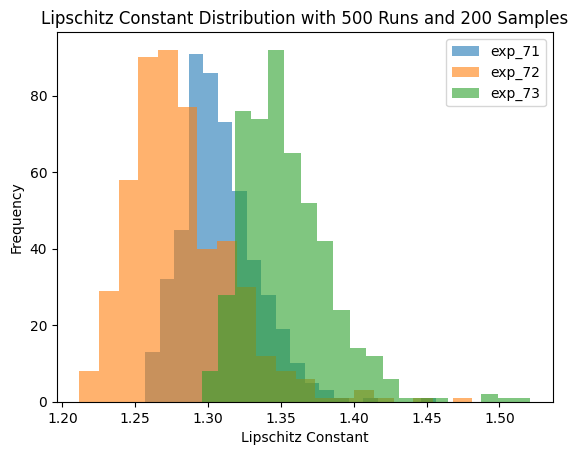

In [39]:
import matplotlib.pyplot as plt
num_runs = 500
n_samples = 200
plt.hist(results_71, bins=20, alpha=0.6, label='exp_71')
plt.hist(results_72, bins=20, alpha=0.6, label='exp_72')
plt.hist(results_73, bins=20, alpha=0.6, label='exp_73')
plt.xlabel('Lipschitz Constant')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Lipschitz Constant Distribution with {num_runs} Runs and {n_samples} Samples')
plt.show()

In [21]:
alpha=0.05
mean_lip_71 = np.mean(results_71)
lower_bound_71 = np.percentile(results_71, 100 * (alpha / 2))
upper_bound_71 = np.percentile(results_71, 100 * (1 - alpha / 2))

mean_lip_72 = np.mean(results_72)
lower_bound_72 = np.percentile(results_72, 100 * (alpha / 2))
upper_bound_72 = np.percentile(results_72, 100 * (1 - alpha / 2))

print(f"Data 71 - Mean Lipschitz: {mean_lip_71}, 95% CI: {(lower_bound_71, upper_bound_71)}")
print(f"Data 72 - Mean Lipschitz: {mean_lip_72}, 95% CI: {(lower_bound_72, upper_bound_72)}")

Data 71 - Mean Lipschitz: 1.347561881542206, 95% CI: (1.3098770916461944, 1.4080067247152328)
Data 72 - Mean Lipschitz: 1.3275544846057892, 95% CI: (1.2786125540733337, 1.392762616276741)


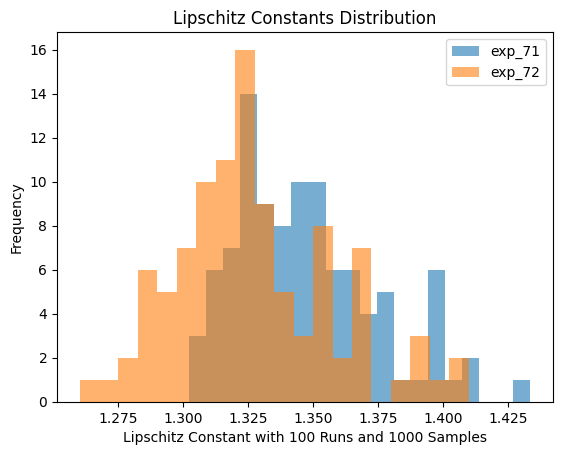

In [28]:
import matplotlib.pyplot as plt
# 绘制 Lipschitz 常数的分布
plt.hist(results_71, bins=20, alpha=0.6, label='exp_71')
plt.hist(results_72, bins=20, alpha=0.6, label='exp_72')
plt.xlabel('Lipschitz Constant with 100 Runs and 1000 Samples')
plt.ylabel('Frequency')
plt.legend()
plt.title('Lipschitz Constants Distribution')
plt.show()

# Visualize

In [122]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random

def load_data(file_path, label=None):
    """
    加载数据和标签。
    Args:
        file_path: 数据文件路径
        label: 标签过滤条件，如果为 None，则返回所有数据
    Returns:
        data: 输入数据，形状为 (num_samples, num_features)
        labels: 数据标签
    """
    data_all = np.load(file_path)
    data_ = data_all['z']
    labels = data_all['labels']
    if label is not None:
        data = data_[labels == label]
        labels = labels[labels == label]
    else:
        data = data_
    return data, labels

def tsne_visualization(data, labels, selected_labels,name):
    """
    使用 t-SNE 对数据进行降维，并进行可视化。
    Args:
        data: 输入数据，形状为 (num_samples, num_features)
        labels: 数据标签
        n_classes: 随机选择的类别数量
    """
    # 随机选择 n_classes 个类别
    # unique_labels = np.unique(labels)
    # selected_labels = random.sample(list(unique_labels), n_classes)

    # 选择对应类别的数据
    selected_data = []
    selected_labels_for_data = []
    for label in selected_labels:
        selected_data.append(data[labels == label])
        selected_labels_for_data.extend([label] * data[labels == label].shape[0])

    selected_data = np.vstack(selected_data)
    selected_labels_for_data = np.array(selected_labels_for_data)

    # t-SNE 降维
    tsne = TSNE(n_components=2, random_state=42)
    reduced_data = tsne.fit_transform(selected_data)

    # 绘制可视化
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=selected_labels_for_data, cmap='tab10', s=50)
    
    # 添加类别标签
    plt.legend(handles=scatter.legend_elements()[0], labels=[str(label) for label in selected_labels])
    plt.title(f'{name}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(scatter)
    plt.show()


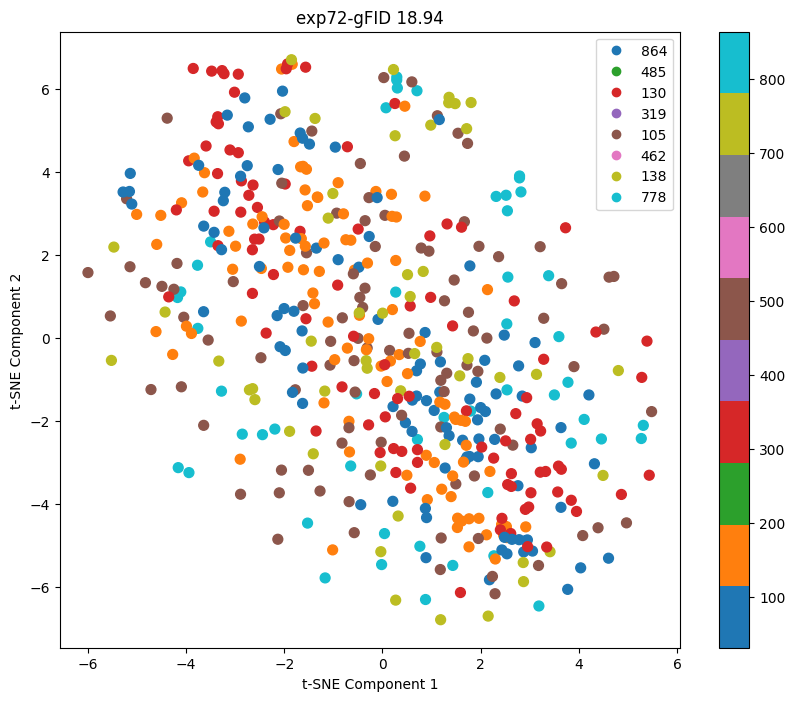

In [140]:
# 文件路径
file_path = '/cpfs01/user/hanyujin/ldm/latent/exp072-vit_dinob_full_ae128_d16_movqv2_latent_dropmin005-075.npz'
data, labels = load_data(file_path)
tsne_visualization(data, labels, selected_labels,name = 'exp72-gFID 18.94')

# Mode

In [17]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
import numpy as np
from tqdm import trange
import numpy as np

# class GMM(nn.Module):
#     def __init__(self, n_components, n_features):
#         super(GMM, self).__init__()
#         self.n_components = n_components
#         self.n_features = n_features
        
#         # Initialize the weights, means, and covariances
#         self.weights = nn.Parameter(torch.ones(n_components) / n_components)  # Mixing coefficients
#         self.means = nn.Parameter(torch.randn(n_components, n_features))  # Means of Gaussians
#         self.covariances = nn.Parameter(torch.eye(n_features).repeat(n_components, 1, 1))  # Covariances

#     def forward(self, x):
#         # Calculate the log-likelihood for each data point and component
#         likelihoods = []
#         for i in range(self.n_components):
#             dist = MultivariateNormal(self.means[i], self.covariances[i])
#             likelihoods.append(torch.exp(dist.log_prob(x)))
#         likelihoods = torch.stack(likelihoods, dim=-1)  # Shape: [n_samples, n_components]
        
#         # Weighted sum of likelihoods
#         weighted_likelihoods = likelihoods * self.weights
#         total_likelihood = weighted_likelihoods.sum(dim=-1)  # Shape: [n_samples]
#         return torch.log(total_likelihood + 1e-10).mean()  # Return average log-likelihood

#     def bic(self, x):
#         n_samples = x.size(0)
#         n_params = self.n_components * (1 + self.n_features + self.n_features * self.n_features)
#         log_likelihood = self.forward(x).item() * n_samples
#         bic = n_params * np.log(n_samples) - 2 * log_likelihood
#         return bic


class GMM(nn.Module):
    def __init__(self, n_components, n_features):
        super(GMM, self).__init__()
        self.n_components = n_components
        self.n_features = n_features
        
        # Initialize the weights, means, and covariances
        self.weights = nn.Parameter(torch.ones(n_components) / n_components)  # Mixing coefficients
        self.means = nn.Parameter(torch.randn(n_components, n_features))  # Means of Gaussians
        self.log_covariances = nn.Parameter(torch.zeros(n_components, n_features))  # Log-diagonal covariances

    def forward(self, x):
        # Calculate the log-likelihood for each data point and component
        likelihoods = []
        for i in range(self.n_components):
            diag_cov = torch.exp(self.log_covariances[i])  # Ensure positive covariance
            dist = MultivariateNormal(self.means[i], torch.diag(diag_cov))
            likelihoods.append(dist.log_prob(x))  # Use log_prob directly
        likelihoods = torch.stack(likelihoods, dim=-1)  # Shape: [n_samples, n_components]
        
        # Weighted sum of log-likelihoods
        weighted_log_likelihoods = likelihoods + torch.log(self.weights + 1e-10)  # Avoid log(0)
        total_likelihood = torch.logsumexp(weighted_log_likelihoods, dim=-1)  # Log-sum-exp trick
        return total_likelihood.mean()  # Return average log-likelihood

    def bic(self, x):
        n_samples = x.size(0)
        n_params = self.n_components * (1 + self.n_features + self.n_features)  # Adjust for diagonal covariance
        log_likelihood = self.forward(x).item() * n_samples
        bic = n_params * np.log(n_samples) - 2 * log_likelihood
        return bic

def train_gmm(data, n_components, batch_size, n_iter=100, lr=0.01, device='cpu'):
    n_features = data.shape[1]
    model = GMM(n_components, n_features).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    for iter in range(n_iter):
        perm = torch.randperm(data.size(0))  # Shuffle data
        batch_losses = []

        for i in range(0, data.size(0), batch_size):
            batch_idx = perm[i:i + batch_size]
            batch = data[batch_idx].to(device)

            optimizer.zero_grad()
            loss = -model(batch)  # Maximize log-likelihood
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                model.weights.data = model.weights.data / model.weights.data.sum()
            # print("log_covariances:",model.log_covariances)
            # print("mean:",model.means)
            
            batch_losses.append(loss.item())

        # Store the average batch loss for each epoch
        losses.append(np.mean(batch_losses))
        if iter % 10 ==0:
            print(f"Interation {iter} with loss {np.mean(batch_losses)}")
    return model, losses


def calculate_bic(data,min_components ,max_components, batch_size, n_iter=100, lr=0.001, device='cpu'):
    bics = []
    all_loss = []
    for n_components in range(min_components, max_components + 1):
        model, losses = train_gmm(data, n_components, batch_size, n_iter, lr, device)
        bic = model.bic(data.to(device))
        bics.append(bic)
        all_loss.extend(losses)
    return bics, all_loss


In [21]:
# Load data
file_path = "/cpfs04/user/hanyujin/ldm/latent/exp071-vit_dinob_full_ae128_d16_movqv2_latent_no_drop_token.npz"
data_all = np.load(file_path)
data = data_all['z']
n_label = 5
labels = data_all['labels']
unique_labels = np.unique(labels)
if n_label is not None:
    random_labels = np.random.choice(unique_labels, size=n_label, replace=False)
    mask = np.isin(labels, random_labels)
    data = data[mask]
    labels = labels[mask]
mean = data.mean(axis=0)
std = data.std(axis=0)
data = (data - mean) / (std + 1e-8)  # 标准化
print("data shape:",data.shape)
data = torch.tensor(data, dtype=torch.float32)

# Set parameters
min_components = 5
max_components = 5
batch_size = 64  # Set your batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train GMM and calculate BIC for different numbers of components
bics, all_loss = calculate_bic(data, min_components, max_components, batch_size, n_iter=500, lr=0.01, device=device)

data shape: (250, 4096)
Interation 0 with loss 7698.5843505859375
Interation 10 with loss 6524.7506103515625
Interation 20 with loss 6145.0030517578125
Interation 30 with loss 5998.366943359375
Interation 40 with loss 5924.6036376953125
Interation 50 with loss 5879.4874267578125
Interation 60 with loss 5851.7166748046875
Interation 70 with loss 5833.2713623046875
Interation 80 with loss 5821.943603515625
Interation 90 with loss 5816.49658203125
Interation 100 with loss 5811.894775390625
Interation 110 with loss 5808.09423828125
Interation 120 with loss 5805.2269287109375
Interation 130 with loss 5803.2386474609375
Interation 140 with loss 5799.8916015625
Interation 150 with loss 5799.1527099609375
Interation 160 with loss 5797.9573974609375
Interation 170 with loss 5796.6488037109375
Interation 180 with loss 5794.256103515625
Interation 190 with loss 5798.2872314453125
Interation 200 with loss 5797.1651611328125
Interation 210 with loss 5789.9560546875
Interation 220 with loss 5791.319

In [19]:
# Load data
file_path = "/cpfs04/user/hanyujin/ldm/latent/exp073-vit_dinob_full_ae128_d16_movqv2_latent_dropmin005-075_decoders.npz"
data_all = np.load(file_path)
data = data_all['z']
n_label = 5
labels = data_all['labels']
unique_labels = np.unique(labels)
if n_label is not None:
    random_labels = np.random.choice(unique_labels, size=n_label, replace=False)
    mask = np.isin(labels, random_labels)
    data = data[mask]
    labels = labels[mask]
mean = data.mean(axis=0)
std = data.std(axis=0)
data = (data - mean) / (std + 1e-8)  # 标准化
print("data shape:",data.shape)
data = torch.tensor(data, dtype=torch.float32)

# Set parameters
min_components = 5
max_components = 5
batch_size = 64  # Set your batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train GMM and calculate BIC for different numbers of components
bics, all_loss = calculate_bic(data, min_components, max_components, batch_size, n_iter=500, lr=0.01, device=device)

data shape: (250, 4096)
Interation 0 with loss 7689.3099365234375
Interation 10 with loss 6533.5966796875
Interation 20 with loss 6126.5689697265625
Interation 30 with loss 5938.5411376953125
Interation 40 with loss 5848.189453125
Interation 50 with loss 5797.587890625
Interation 60 with loss 5766.568359375
Interation 70 with loss 5744.8726806640625
Interation 80 with loss 5731.7674560546875
Interation 90 with loss 5720.9862060546875
Interation 100 with loss 5712.3531494140625
Interation 110 with loss 5705.6385498046875
Interation 120 with loss 5700.6680908203125
Interation 130 with loss 5698.287841796875
Interation 140 with loss 5693.0281982421875
Interation 150 with loss 5691.419189453125
Interation 160 with loss 5689.1455078125
Interation 170 with loss 5684.370361328125
Interation 180 with loss 5683.354736328125
Interation 190 with loss 5681.097412109375
Interation 200 with loss 5679.025634765625
Interation 210 with loss 5677.5218505859375
Interation 220 with loss 5677.53857421875
I

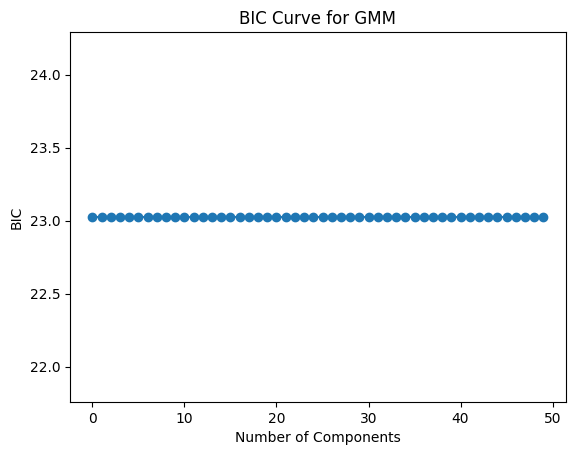

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(50), all_loss[:50], marker='o')
plt.xlabel("Number of Components")
plt.ylabel("BIC")
plt.title("BIC Curve for GMM")
plt.show()


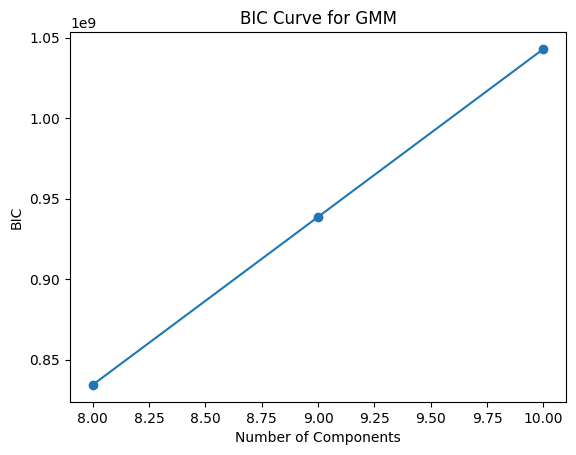

In [8]:
# Plot BIC curve
import matplotlib.pyplot as plt
plt.plot(range(min_components, max_components + 1), bics, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("BIC")
plt.title("BIC Curve for GMM")
plt.show()

In [1]:
import numpy as np
a = np.load("/cpfs04/user/hanyujin/ldm/exp071-vit_dinob_full_ae128_d16_movqv2_latent_no_drop_token/n01440764/n01440764_18.JPEG.npz")

In [4]:
a['zq'].shape

(128, 32)

In [20]:
import os
import numpy as np
from tqdm import tqdm
import h5py
import random

def load_and_flatten_latents(base_path, output_file, num_labels=None):
    """
    Load latent variables from a specified number of random label folders, flatten them, and save to an HDF5 file.
    Also extracts the corresponding labels and saves them to the HDF5 file.

    Args:
        base_path (str): The root directory containing label folders with latent variable files.
        output_file (str): Path to the HDF5 file to save the data and labels.
        num_labels (int, optional): Number of label folders to randomly load. If -1 or None, loads all folders.

    Returns:
        None
    """
    # Get all label folders
    label_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

    # Randomly select a subset of label folders if num_labels is specified and not -1
    if num_labels is not None and num_labels != -1:
        label_folders = random.sample(label_folders, min(num_labels, len(label_folders)))

    # Prepare to write to HDF5
    with h5py.File(output_file, 'w') as h5f:
        # Create datasets for data and labels
        data_ds = h5f.create_dataset('data', (0, 128 * 32), maxshape=(None, 128 * 32), dtype='float32', chunks=True)
        labels_ds = h5f.create_dataset('labels', (0,), maxshape=(None,), dtype=h5py.string_dtype(encoding='utf-8'), chunks=True)

        for label_folder in tqdm(label_folders, desc="Processing label folders"):
            label_path = os.path.join(base_path, label_folder)

            # Process all .npz files in the directory
            for file_name in tqdm(os.listdir(label_path), desc=f"Processing files in {label_folder}", leave=False):
                if file_name.endswith(".npz"):
                    file_path = os.path.join(label_path, file_name)

                    try:
                        # Load the latent variable file
                        data = np.load(file_path)
                        latent = data['zq']

                        # Flatten the latent variable
                        flattened_latent = latent.flatten()

                        # Resize HDF5 datasets to accommodate new data
                        data_ds.resize(data_ds.shape[0] + 1, axis=0)
                        labels_ds.resize(labels_ds.shape[0] + 1, axis=0)

                        # Append data and label
                        data_ds[-1] = flattened_latent
                        labels_ds[-1] = label_folder  # Store label as UTF-8 string

                    except Exception as e:
                        print(f"Error loading file {file_path}: {e}")

def filter_by_labels(h5_file, select_labels=None, n_label=0):
    """
    Filter data and labels from an HDF5 file based on selected or randomly sampled labels.

    Args:
        h5_file (str): Path to the HDF5 file containing data and labels.
        select_labels (list, optional): List of labels to filter. If None, random labels will be selected.
        n_label (int): Number of labels to randomly select if select_labels is None. Set to -1 or 0 to load all.

    Returns:
        tuple: Filtered data and labels as numpy arrays.
    """
    with h5py.File(h5_file, 'r') as h5f:
        data = h5f['data'][:]
        labels = h5f['labels'][:]  # Labels are stored as strings

        unique_labels = list(np.unique(labels))  # Ensure output is a list of strings

        if select_labels is not None and n_label != 0:
            random_labels = np.array(select_labels)
        elif select_labels is None and n_label > 0:
            random_labels = np.random.choice(unique_labels, size=n_label, replace=False)
        elif n_label == -1 or n_label == 0:
            random_labels = unique_labels  # Load all labels
        else:
            random_labels = np.array([-1])

        if random_labels[0] != -1:
            mask = np.isin(labels, random_labels)
            data = data[mask]
            labels = labels[mask]

        return data, labels

# Example usage:
# h5_file = "latent_data.h5"
# selected_labels = ["n03590841"]  # Specify labels to load
# n_label_to_load = -1  # Set to -1 to load all labels

# filtered_data, filtered_labels = filter_by_labels(h5_file, select_labels=selected_labels, n_label=n_label_to_load)

# print(f"Filtered data shape: {filtered_data.shape}")
# print(f"Filtered labels: {filtered_labels}")


# Example usage:
base_path = "/cpfs04/user/hanyujin/ldm/exp071-vit_dinob_full_ae128_d16_movqv2_latent_no_drop_token"
output_file = "latent_data.h5"
num_labels_to_load = 2  # Load data from 1 random label folder
load_and_flatten_latents(base_path, output_file, num_labels=num_labels_to_load)

print(f"Data and labels saved to {output_file}")


Processing label folders: 100%|██████████| 2/2 [00:11<00:00,  5.76s/it]

Data and labels saved to latent_data.h5


In [21]:
import h5py

# 打开 HDF5 文件
with h5py.File("latent_data.h5", "r") as h5f:
    # 提取 latent data 和 labels
    latent_data = h5f['data'][:]  # 所有 latent data
    labels = h5f['labels'][:]  # 所有 labels


In [22]:
list(np.unique(labels))

[b'n02101388', b'n04409515']

In [2]:

def load_and_flatten_latents(base_path, output_file, num_labels=None, select_labels=None):
    """
    Load latent variables from specific or random label folders, flatten them, and save to an HDF5 file.
    Args:
        base_path (str): The root directory containing label folders with latent variable files.
        output_file (str): Path to the HDF5 file to save the data and labels.
        num_labels (int, optional): Number of label folders to randomly load. If -1 or None, loads all folders.
        select_labels (list, optional): Specific labels (subfolder names) to load.
    Returns:
        None
    """
    # Get all label folders
    label_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

    # If specific labels are provided, filter to include only those folders
    if select_labels is not None:
        label_folders = [f for f in label_folders if f in select_labels]

    # If no specific labels are provided, and num_labels is specified, select random folders
    elif num_labels is not None and num_labels != -1:
        label_folders = random.sample(label_folders, min(num_labels, len(label_folders)))

    # Prepare to write to HDF5
    with h5py.File(output_file, 'w') as h5f:
        # Create datasets for data and labels
        data_ds = h5f.create_dataset('data', (0, 128 * 32), maxshape=(None, 128 * 32), dtype='float32', chunks=True)
        labels_ds = h5f.create_dataset('labels', (0,), maxshape=(None,), dtype=h5py.string_dtype(encoding='utf-8'), chunks=True)

        for label_folder in tqdm(label_folders, desc="Processing label folders"):
            label_path = os.path.join(base_path, label_folder)

            # Process all .npz files in the directory
            for file_name in tqdm(os.listdir(label_path), desc=f"Processing files in {label_folder}", leave=False):
                if file_name.endswith(".npz"):
                    file_path = os.path.join(label_path, file_name)

                    try:
                        # Load the latent variable file
                        data = np.load(file_path)
                        latent = data['zq']

                        # Flatten the latent variable
                        flattened_latent = latent.flatten()

                        # Resize HDF5 datasets to accommodate new data
                        data_ds.resize(data_ds.shape[0] + 1, axis=0)
                        labels_ds.resize(labels_ds.shape[0] + 1, axis=0)

                        # Append data and label
                        data_ds[-1] = flattened_latent
                        labels_ds[-1] = label_folder  # Store label as UTF-8 string

                    except Exception as e:
                        print(f"Error loading file {file_path}: {e}")


In [4]:
file_path = "/cpfs04/user/hanyujin/ldm/exp072-vit_dinob_full_ae128_d16_movqv2_latent_dropmin005-075"
    # Load data
output_file = "latent_data.h5"
select_labels = ["n04259630"]
load_and_flatten_latents(file_path, output_file, select_labels=select_labels)

with h5py.File("latent_data.h5", "r") as h5f:
    data = h5f['data'][:] 
    labels = h5f['labels'][:]  

Processing label folders: 0it [00:00, ?it/s]


In [25]:
list(np.unique(selected_labels))

['n01496331', 'n04273569']

# Theory

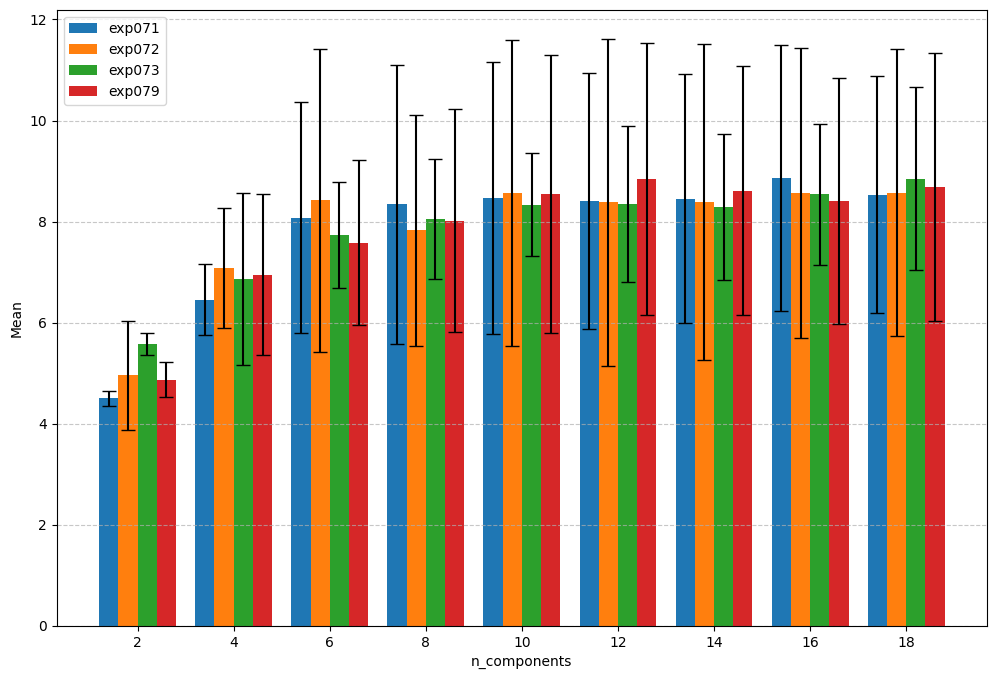

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 文件路径列表
file_paths = [
    '/cpfs04/user/hanyujin/ldm/results/exp071_selectedlabelnum0_reduceUMAP_selectedlabel[-1].csv',
    '/cpfs04/user/hanyujin/ldm/results/exp072_selectedlabelnum0_reduceUMAP_selectedlabel[-1].csv',
    '/cpfs04/user/hanyujin/ldm/results/exp073_selectedlabelnum0_reduceUMAP_selectedlabel[-1].csv',
    '/cpfs04/user/hanyujin/ldm/results/exp079_selectedlabelnum0_reduceUMAP_selectedlabel[-1].csv'
]

# 数据集标签
labels = ['exp071', 'exp072', 'exp073', 'exp079']

# 初始化存储结果的字典
grouped_data = {}

# 读取每个数据集并计算均值和标准差
for file_path, label in zip(file_paths, labels):
    try:
        data = pd.read_csv(file_path)
        # 检查是否包含所需列
        required_columns = ['n_components', 'cluster', 'mean_norm', 'cov_norm']
        if all(col in data.columns for col in required_columns):
            # 计算 mean_norm 和 cov_norm 的和
            data['sum_norm'] = data['mean_norm'] #+ data['cov_norm']

            # 按 n_components 分组，计算均值和标准差
            grouped = data.groupby('n_components')['sum_norm']
            mean_values = grouped.mean()
            std_values = grouped.std()

            # 存储结果
            grouped_data[label] = {
                'mean': mean_values,
                'std': std_values
            }
        else:
            print(f"Dataset {label} does not contain the required columns.")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred while processing {label}: {e}")

# 绘制分组柱状图
plt.figure(figsize=(12, 8))
x = np.arange(len(grouped_data[labels[0]]['mean']))  # 取第一个数据集的 x 轴
bar_width = 0.2

for i, label in enumerate(labels):
    mean_values = grouped_data[label]['mean']
    std_values = grouped_data[label]['std']
    plt.bar(x + i * bar_width, mean_values, yerr=std_values, capsize=5, width=bar_width, label=label)

# 设置图表属性
plt.xlabel('n_components')
plt.ylabel('Mean')
# plt.title('MEAN')
plt.xticks(x + bar_width * (len(labels) - 1) / 2, mean_values.index)  # 设置 x 轴刻度标签
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


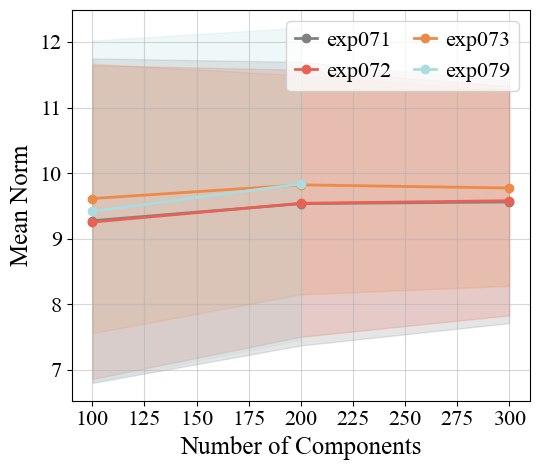

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# 文件路径列表
file_paths = [
    '/cpfs04/user/hanyujin/ldm/results/exp071_selectedlabelnum0_reduceUMAP_selectedlabel[-1].csv',
    '/cpfs04/user/hanyujin/ldm/results/exp072_selectedlabelnum0_reduceUMAP_selectedlabel[-1].csv',
    '/cpfs04/user/hanyujin/ldm/results/exp073_selectedlabelnum0_reduceUMAP_selectedlabel[-1].csv',
    '/cpfs04/user/hanyujin/ldm/results/exp079_selectedlabelnum0_reduceUMAP_selectedlabel[-1].csv'
]

# 数据集标签
labels = ['exp071', 'exp072', 'exp073', 'exp079']

# 初始化存储结果的字典
grouped_data = {}

# 读取每个数据集并计算均值和标准差
for file_path, label in zip(file_paths, labels):
    try:
        data = pd.read_csv(file_path)
        # 检查是否包含所需列
        required_columns = ['n_components', 'cluster', 'mean_norm', 'cov_norm']
        if all(col in data.columns for col in required_columns):
            # 计算 mean_norm 和 cov_norm 的和
            data['sum_norm'] = data['mean_norm']#+ data['cov_norm']

            # 按 n_components 分组，计算均值和标准差
            grouped = data.groupby('n_components')['sum_norm']
            mean_values = grouped.mean()
            std_values = grouped.std()

            # 存储结果
            grouped_data[label] = {
                'mean': mean_values,
                'std': std_values
            }
        else:
            print(f"Dataset {label} does not contain the required columns.")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred while processing {label}: {e}")

# 绘制分组柱状图
plt.figure(figsize=(12, 8))
x = np.arange(len(grouped_data[labels[0]]['mean']))  # 取第一个数据集的 x 轴
bar_width = 0.2

for i, label in enumerate(labels):
    mean_values = grouped_data[label]['mean']
    std_values = grouped_data[label]['std']
    plt.bar(x + i * bar_width, mean_values, yerr=std_values, capsize=5, width=bar_width, label=label)

# 设置图表属性
plt.xlabel('n_components')
plt.ylabel('mean_norm')
# plt.title('MEAN')
plt.xticks(x + bar_width * (len(labels) - 1) / 2, mean_values.index)  # 设置 x 轴刻度标签
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)


# 保存图片到指定路径
save_path = "/cpfs04/user/hanyujin/ldm/figures"
if not os.path.exists(save_path):
    os.makedirs(save_path)

save_file_path = os.path.join(save_path, 'mean_norm.pdf')
plt.savefig(save_file_path)
print(f"Chart saved to {save_file_path}")

plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (4,).

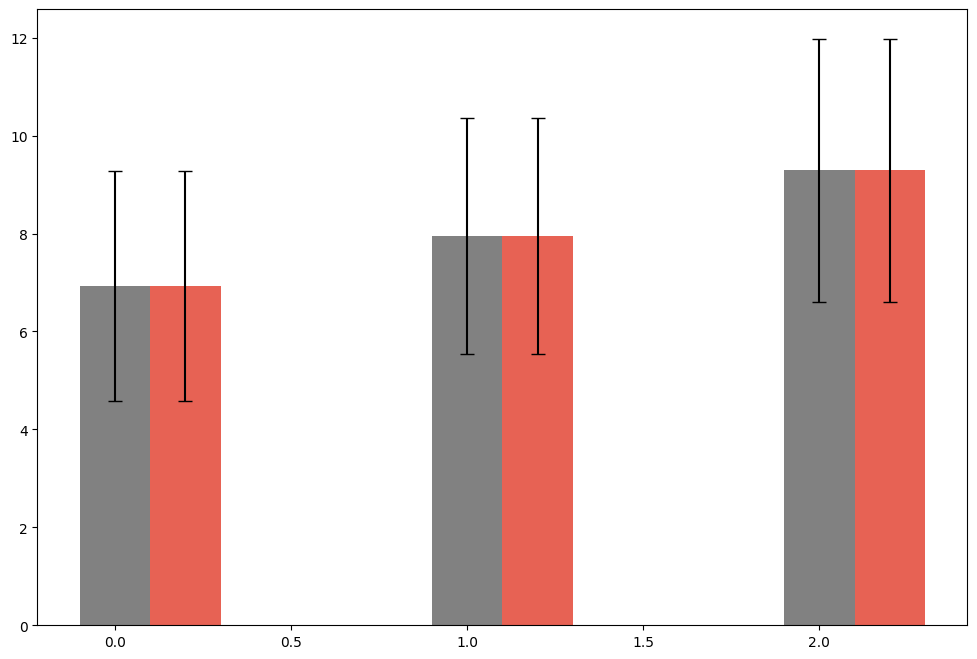

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# 文件路径列表
file_paths = [
    '/cpfs04/user/hanyujin/ldm/results/exp071_selectedlabelnum0_reduceUMAP_selectedlabel[-1]_min2max20.csv',
    '/cpfs04/user/hanyujin/ldm/results/exp071_selectedlabelnum0_reduceUMAP_selectedlabel[-1]_min2max20.csv',
    '/cpfs04/user/hanyujin/ldm/results/vavae_selectedlabelnum0_reduceUMAP_selectedlabel[-1]_min2max20.csv',
    '/cpfs04/user/hanyujin/ldm/results/exp099_selectedlabelnum0_reduceUMAP_selectedlabel[-1]_min2max20.csv'
]

# 数据集标签
labels = ['exp071', 'exp072', 'exp073', 'exp079']

# 初始化存储结果的字典
grouped_data = {}

# 读取每个数据集并计算均值和标准差
for file_path, label in zip(file_paths, labels):
    try:
        data = pd.read_csv(file_path)
        # 检查是否包含所需列
        required_columns = ['n_components', 'cluster', 'mean_norm', 'cov_norm']
        if all(col in data.columns for col in required_columns):
            # 计算 mean_norm 和 cov_norm 的和
            data['sum_norm'] = data['mean_norm']  # + data['cov_norm']

            # 按 n_components 分组，计算均值和标准差
            grouped = data.groupby('n_components')['sum_norm']
            mean_values = grouped.mean()
            std_values = grouped.std()

            # 存储结果
            grouped_data[label] = {
                'mean': mean_values,
                'std': std_values
            }
        else:
            print(f"Dataset {label} does not contain the required columns.")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred while processing {label}: {e}")

# 定义颜色
rgb_colors = [
    (129, 129, 129),
    (231, 98, 84),
    (238, 138, 71),
    (170, 220, 224),
    (82, 143, 173),
]
colors = ['#{:02x}{:02x}{:02x}'.format(r, g, b) for r, g, b in rgb_colors]

# 绘制分组柱状图
plt.figure(figsize=(12, 8))
x = np.arange(len(grouped_data[labels[0]]['mean']))  # 取第一个数据集的 x 轴
bar_width = 0.2

for i, label in enumerate(labels):
    mean_values = grouped_data[label]['mean']
    std_values = grouped_data[label]['std']
    plt.bar(x + i * bar_width, mean_values, yerr=std_values, capsize=5, width=bar_width, label=label, color=colors[i])

# 设置图表属性
plt.xlabel('n_components', fontsize=14)
plt.ylabel('mean_norm', fontsize=14)
plt.xticks(x + bar_width * (len(labels) - 1) / 2, mean_values.index, fontsize=12)  # 设置 x 轴刻度标签
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 保存图片到指定路径
save_path = "/cpfs04/user/hanyujin/ldm/figures"
if not os.path.exists(save_path):
    os.makedirs(save_path)

save_file_path = os.path.join(save_path, 'mean_norm.pdf')
plt.savefig(save_file_path, bbox_inches='tight')
print(f"Chart saved to {save_file_path}")

plt.show()

In [3]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv("/cpfs04/user/hanyujin/ldm/results/exp071_selectedlabelnum0_reduceUMAP_selectedlabel[-1]_min2max20.csv")

# 按 n_components 分组，并找到 mean_norm 最大的行
max_mean_norm_rows = df.loc[df.groupby("n_components")['mean_norm'].idxmax()]

# 输出结果
print(max_mean_norm_rows)


    n_components  cluster  mean_norm  cov_norm  second_moment  \
4              5        5  10.244650  1.399631     117.385351   
11            10        7  12.028518  3.041674     164.569001   
37            50       23  15.426130  0.209136     239.786335   

    min_mean_distance  
4            6.621232  
11           7.195312  
37           2.917764  


In [4]:
import pandas as pd
components = [5,10,50]
ae = [10.244650,12.028518,15.426130]
vae = [10.989738,10.893665,12.504686]
# 读取CSV文件
df = pd.read_csv("/cpfs04/user/hanyujin/ldm/results/exp077_selectedlabelnum0_reduceUMAP_selectedlabel[-1]_min2max20.csv")

# 按 n_components 分组，并找到 mean_norm 最大的行
max_mean_norm_rows = df.loc[df.groupby("n_components")['mean_norm'].idxmax()]

# 输出结果
print(max_mean_norm_rows)


     n_components  cluster  mean_norm   cov_norm  second_moment  \
1               5        2  10.989738  10.013835     220.886864   
15             10        6  10.893665   1.195106     129.909158   
22             50        3  12.504686   0.641521     162.014686   
140           100       71  12.806146   0.660064     169.333811   
357           200      188  13.181172   0.419207     177.099345   

     min_mean_distance  
1             8.156068  
15            6.026656  
22            3.247828  
140           2.364001  
357           2.475707  


In [5]:
import pandas as pd
components = [5,10,50]
ae = [10.244650,12.028518,15.426130]
vae = [10.989738,10.893665,12.504686]
mtkvae = [8.544316,9.863484,17.656849]
# 读取CSV文件
df = pd.read_csv("/cpfs04/user/hanyujin/ldm/results/exp099_selectedlabelnum0_reduceUMAP_selectedlabel[-1]_min2max20.csv")

# 按 n_components 分组，并找到 mean_norm 最大的行
max_mean_norm_rows = df.loc[df.groupby("n_components")['mean_norm'].idxmax()]

# 输出结果
print(max_mean_norm_rows)


    n_components  cluster  mean_norm  cov_norm  second_moment  \
4              5        5   8.544316  3.435477     101.778696   
13            10        9   9.863484  4.726108     128.064010   
57            50       43  17.656849  0.272824     312.896660   

    min_mean_distance  
4            7.994369  
13           4.861472  
57           2.508530  


In [6]:
import pandas as pd
components = [5,10,50]
ae = [10.244650,12.028518,15.426130]
vae = [10.989738,10.893665,12.504686]
vavae = [8.878362,12.212157,15.718337]
mtkvae = [8.544316,9.863484,17.656849]
# 读取CSV文件
df = pd.read_csv("/cpfs04/user/hanyujin/ldm/results/vavae_selectedlabelnum0_reduceUMAP_selectedlabel[-1]_min2max20.csv")

# 按 n_components 分组，并找到 mean_norm 最大的行
max_mean_norm_rows = df.loc[df.groupby("n_components")['mean_norm'].idxmax()]

# 输出结果
print(max_mean_norm_rows)


     n_components  cluster  mean_norm  cov_norm  second_moment  \
2               5        3   8.878362  3.216538     103.849019   
7              10        3  12.212157  0.893567     155.727673   
61             50       47  15.718337  0.395973     249.297200   
241           300      177  14.585015  0.295755     215.275206   

     min_mean_distance  
2             9.376916  
7             7.125622  
61            3.226694  
241           3.975911  


In [ ]:
def plot_metric(scheduler='ddim_250', metric='fid'):

    with open(f'./results/eval_ldm_pretrain_mscoco_{scheduler}_fid_clip_pr_llm.pkl', 'rb') as f:
        results = pickle.load(f)[metric]
    # print(results)

    # model_list = results['model']
    model_list = ['ldm_cc3m_clean', 'ldm_cc3m_llm_random_noise_2.5', 'ldm_cc3m_llm_random_noise_5', 'ldm_cc3m_llm_random_noise_7.5', 'ldm_cc3m_llm_random_noise_10', 'ldm_cc3m_llm_random_noise_15', 'ldm_cc3m_llm_random_noise_20']
    guidance_scale_list = [s for s in list(results.keys()) if s != 'model']
    guidance_scale_list = [s for s in guidance_scale_list if s != 9]
    guidance_scale_list = [s for s in guidance_scale_list if s != 7.5]
    print(guidance_scale_list)
    model_labels = [r'$\eta$=0\%', r'$\eta$=2.5\%', r'$\eta$=5\%', r'$\eta$=7.5\%', r'$\eta$=10\%', r'$\eta$=15\%', r'$\eta$=20\%']
    # colors = sns.color_palette("husl", len(model_labels))
    # colors = sns.color_palette("Spectral", len(model_labels))

    rgb_colors = [
        # (255, 230, 183),
        (129,129,129),
        (231, 98, 84),
        (238, 138, 71),
        # (247, 170, 88),
        (255, 208, 111),
        (170, 220, 224),
        (114, 188, 213),
        (82, 143, 173),
        (55, 103, 149),
    ]   
    colors = ['#{:02x}{:02x}{:02x}'.format(r,g,b) for r,g,b in rgb_colors]
    print(colors)
    # TODO: replace 3 and 4
    # colors[3] = '#a6bddb'
    # colors[4] = '#43a2ca' 
    # colors[5]
    # colors[5] = colors[6]
    # colors[6] = '#43a2ca'
    # colors[6] = '#a6bddb'
    # colors[7] = 

    # colors = [
    #     '#F27970',
    #     '#BB9727',
    #     '#54B345',
    #     '#32B897',
    #     '#05B9E2',
    #     '#8983BF',
    #     '#C76DA2',
    #     '#C76DA2'
    # ]

    plt.figure(figsize=(5.5, 4.8), facecolor='white')

    for i in range(len(model_list)):
        model_results = []
        for scale in guidance_scale_list:

            if metric == 'rmd_score':
                model_results.append(np.mean(results[scale][i]))
            else:
                model_results.append(results[scale][i])
        
        plt.plot(guidance_scale_list, model_results, label=model_labels[i], color=colors[i], linewidth=2.5, marker='o')
    
    plt.xlabel('Guidance Scale', fontsize=24)
    metric_to_ylabel = {
        'fid': 'FID',
         'sfid': 'sFID', 
         'clip_score': 'CLIP Score', 
         'is': 'IS', 
         'prec': 'Precision', 
         'recall': 'Recall',
         'toppr_precision': 'TopPR Precision',
         'toppr_recall': 'TopPR Recall',
         'toppr_fidelity': 'TopPR Fidelity',
         'toppr_diversity': 'TopPR Diversity',
         'toppr_f1': 'TopPR F1',
         'rmd_score': 'RMD',
         'mem_ratio': 'Memorization Ratio',
         'mem_dist': r'Avg. $L_2$ Dist.'
         }
    plt.ylabel(metric_to_ylabel[metric], fontsize=24)
    # if metric == 'fid':
    #     plt.yticks(fontsize=20, ticks=[8, 10, 12, 14, 16, 18, 20, 22], labels=[8, 10, 12, 14, 16, 18, 20, 22])
        
    # else:
    #     plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    # if metric in ['prec', 'recall', 'toppr_f1']:
    #     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
    plt.legend(fontsize=16, handlelength=1.0, handletextpad=0.4, ncol=2, columnspacing=1.0)
    # plt.legend(fontsize=14, handlelength=1.0, handletextpad=0.4)
    plt.tight_layout()
    plt.grid(alpha=0.5)

    plt.savefig(f'/cpfs04/user/hanyujin/ldm/results/gmm_loss.pdf', bbox_inches='tight')

    plt.show()
    plt.close()

for scheduler in ['dpm_50']:
    for metric in ['fid', 'is', 'prec', 'recall', 'sfid', 'toppr_f1', 'rmd_score', 'mem_ratio', 'mem_dist', 'clip_score']:
        plot_metric(scheduler=scheduler, metric=metric)

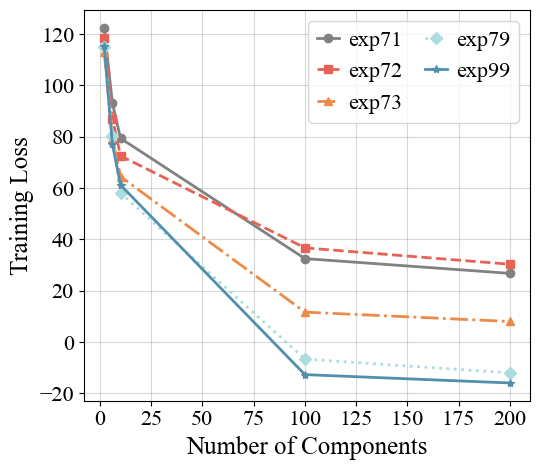

In [1]:
 import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager as fm
import os
# 设置 Times New Roman 字体
times_new_roman_path = "/usr/share/fonts/truetype/msttcorefonts/times.ttf"
if os.path.exists(times_new_roman_path):
    fm.fontManager.addfont(times_new_roman_path)
    plt.rcParams['font.family'] = 'Times New Roman'
else:
    print("Times New Roman font not found. Using default font.")
# Data
n_components = [2, 6, 10, 100, 200]
exp71 = [122.4909833, 93.21542926, 79.3962373, 32.53006059, 26.76935468]
exp72 = [118.3520261, 87.11263277, 72.55985127, 36.7139075, 30.32587788]
exp73 = [113.2359376, 79.24768572, 64.4958559, 11.66180533, 8.010799723]
exp79 = [115.1547594, 80.32680885, 58.15014879, -6.626489414, -12.03348501]
exp99 = [115.365405, 77.18680654, 61.18577181, -12.69603286, -15.94698182]

# Colors
rgb_colors = [
    (129, 129, 129),
    (231, 98, 84),
    (238, 138, 71),
    # (255, 208, 111),
    (170, 220, 224),
    # (114, 188, 213),
    (82, 143, 173),
    # (55, 103, 149),
]
colors = ['#{:02x}{:02x}{:02x}'.format(r, g, b) for r, g, b in rgb_colors]

# Plot
plt.figure(figsize=(5.5, 4.8), facecolor='white')
plt.plot(n_components, exp71, label='exp71', color=colors[0], marker='o', linestyle='-', linewidth=2)
plt.plot(n_components, exp72, label='exp72', color=colors[1], marker='s', linestyle='--', linewidth=2)
plt.plot(n_components, exp73, label='exp73', color=colors[2], marker='^', linestyle='-.', linewidth=2)
plt.plot(n_components, exp79, label='exp79', color=colors[3], marker='D', linestyle=':', linewidth=2)
plt.plot(n_components, exp99, label='exp99', color=colors[4], marker='*', linestyle='-', linewidth=2)

# Labels and title
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Training Loss', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Legend
plt.legend(fontsize=16, handlelength=1.0, handletextpad=0.4, ncol=2, columnspacing=1.0)

# Grid and layout
plt.grid(alpha=0.5)
plt.tight_layout()

# Save and show
plt.savefig('/ldm/results/gmm_loss.pdf', bbox_inches='tight')
plt.show()
plt.close()

/root/miniconda3/envs/yjenv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


The calculated optimal GMM mode of A: 30
The calculated optimal GMM mode of B: 4


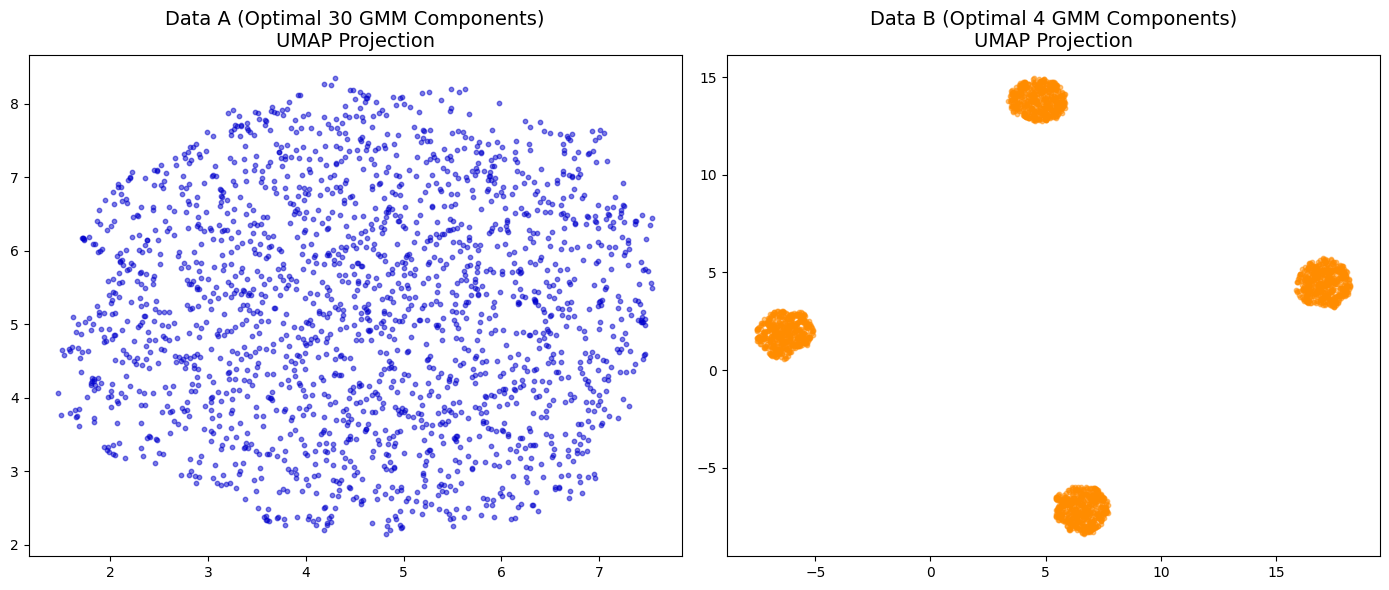

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

np.random.seed(42)

centers_A = np.random.uniform(-0.002, 0.002, size=(30, 10))  # 中心点范围非常小
data_A, _ = make_blobs(n_samples=2000, centers=centers_A, cluster_std=0.1)

centers_B = np.random.uniform(-100, 100, size=(4, 10))  # 中心距离非常大
data_B, _ = make_blobs(n_samples=2000, centers=centers_B, cluster_std=1.0)

reducer = umap.UMAP(random_state=42)
embed_A = reducer.fit_transform(data_A)
embed_B = reducer.fit_transform(data_B)

def optimal_gmm_clusters(data, max_clusters=30):
    aic_scores = []
    for n in range(1, max_clusters+1):
        gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
        gmm.fit(data)
        aic_scores.append(gmm.aic(data))
    optimal_n = np.argmin(aic_scores) + 1
    return optimal_n, aic_scores

optimal_n_A, aic_A = optimal_gmm_clusters(data_A)
optimal_n_B, aic_B = optimal_gmm_clusters(data_B)

print(f"The calculated optimal GMM mode of A: {optimal_n_A}")
print(f"The calculated optimal GMM mode of B: {optimal_n_B}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(embed_A[:, 0], embed_A[:, 1], c='mediumblue', s=10, alpha=0.5)
axes[0].set_title(f'Data A (Optimal {optimal_n_A} GMM Components)\nUMAP Projection', fontsize=14)

axes[1].scatter(embed_B[:, 0], embed_B[:, 1], c='darkorange', s=10, alpha=0.5)
axes[1].set_title(f'Data B (Optimal {optimal_n_B} GMM Components)\nUMAP Projection', fontsize=14)

plt.tight_layout()
plt.show()


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import umap.umap_ as umap

# 生成更复杂的分布A（高维分层结构）
def generate_complex_A(n_samples=1000):
    # 第一层：3个主簇
    main_clusters = np.repeat(np.eye(10)[:3], n_samples//3, axis=0)
    main_noise = np.random.normal(0, 0.3, (n_samples, 10))
    
    # 第二层：每个主簇内创建子结构
    sub_clusters = np.zeros((n_samples, 10))
    for i in range(3):
        mask = np.arange(n_samples) % 3 == i
        sub_clusters[mask, 3+i] = 1  # 每个主簇有独特子结构特征
    sub_noise = np.random.normal(0, 0.2, (n_samples, 10))
    
    # 第三层：非线性交互特征
    nonlin_features = np.zeros((n_samples, 10))
    for j in range(5,10):
        nonlin_features[:,j] = np.sin(main_clusters[:,0]*3 + sub_clusters[:,j-5]*2)
    
    return main_clusters + sub_clusters + nonlin_features + main_noise + sub_noise

# 生成简单但分散的分布B
def generate_simple_B(n_samples=1000):
    # 在更大范围内创建带有空洞的分布
    base = np.random.uniform(-8, 8, (n_samples*2, 20))
    # 创建排斥区域
    norms = np.linalg.norm(base, axis=1)
    mask = (norms < 6) | (norms > 10)
    return base[~mask][:n_samples]

# 生成数据
np.random.seed(42)
X_complex = generate_complex_A(1500)
X_simple = generate_simple_B(1500)

# 标准化
scaler = StandardScaler()
X_complex = scaler.fit_transform(X_complex)
X_simple = scaler.transform(X_simple)

# UMAP参数优化
reducer = umap.UMAP(
    n_neighbors=30,        # 平衡局部与全局结构
    min_dist=0.05,         # 允许更紧密的排列
    n_components=2,
    metric='cosine',       # 更适合分层结构
    repulsion_strength=0.8,# 增强簇间吸引力
    random_state=42
)

# 合并投影
combined = np.vstack([X_complex, X_simple])
labels = np.array(['A']*1500 + ['B']*1500)
embedding = reducer.fit_transform(combined)

# 可视化
plt.figure(figsize=(13,6))

# 原始空间可视化（前两轴）
plt.subplot(121)
plt.scatter(X_complex[:,0], X_complex[:,1], alpha=0.3, label='A (Complex)')
plt.scatter(X_simple[:,0], X_simple[:,1], alpha=0.3, label='B (Simple)')
plt.title('Original Space (First 2 Dimensions)')
plt.legend()

# UMAP投影可视化
plt.subplot(122)
for label, marker in zip(['A', 'B'], ['o', 'x']):
    mask = labels == label
    plt.scatter(embedding[mask,0], embedding[mask,1], 
                alpha=0.5, label=label, marker=marker)
plt.title('UMAP Projection (Optimized Parameters)')
plt.legend()

plt.tight_layout()
plt.show()

# 量化紧凑度（改进指标）
def improved_compactness(embeddings):
    # 计算相互距离的百分位数
    dist_matrix = pairwise_distances(embeddings)
    return np.percentile(dist_matrix, 25)  # 25%分位数距离

compact_A = improved_compactness(embedding[labels=='A'])
compact_B = improved_compactness(embedding[labels=='B'])

print(f"紧凑度比较（值越小越紧凑）:\nA: {compact_A:.3f}\nB: {compact_B:.3f}")

ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required by StandardScaler.